## Links

https://github.com/py-why/EconML/issues/687 - issue opened by Keith

https://econml.azurewebsites.net/_autosummary/econml.iv.dr.DRIV.html#econml.iv.dr.DRIV - Public Module Reference 

https://econml.azurewebsites.net/spec/estimation/orthoiv.html#what-are-the-relevant-estimator-classes - EconML User Guide

https://arxiv.org/pdf/1905.10176 - Machine Learning Estimation of Heterogenous Treatment Effects with Instruments (Vasilis et al.)

## Reproducing the Issue - effect and effect_interval inconsistent dim 

In [53]:
import numpy as np
import pandas as pd
from econml.iv.dr import LinearDRIV, SparseLinearDRIV
import scipy
import matplotlib.pyplot as plt
from econml.utilities import shape, ndim  # import other functions I need
from statsmodels.tools.tools import add_constant


In [2]:
np.random.seed(42)
df = pd.DataFrame(np.random.normal(size = (100, 8)))

# keeps columns as dataframes
Y = df[[0]]
T = df[[1]]
X = df[[2,3,4]]
Z = df[[5]]

In [3]:
est = LinearDRIV().fit(Y=Y, T=T, Z=Z, X=X)

eff = est.effect(X)
lb, ub = est.effect_interval(X)
print(eff.shape)
print(lb.shape)

Not all column names are strings. Coercing to strings for now.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vect

ValueError: einstein sum subscripts string contains too many subscripts for operand 0

In [ ]:
eff[:5]

array([[ 2.37372932],
       [ 0.16503574],
       [-2.71786303],
       [ 1.04051282],
       [-0.63110476]])

## _gen_model_final method with 1) df and 2) array inputs

### df

In [5]:
np.random.seed(42)
df = pd.DataFrame(np.random.normal(size = (100, 6)))

# keeps columns as dataframes
Y = df[[0]]
T = df[[1]]
X = df[[2,3,4]]
Z = df[[5]]

est_df = LinearDRIV().fit(Y=Y, T=T, Z=Z, X=X)

# StatsModelsLinearRegression = est._gen_model_final()
# StatsModelsLinearRegression.fit(T, Y)

Not all column names are strings. Coercing to strings for now.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vect

In [7]:
Y[:5]

,0
0,0.496714
1,1.579213
2,0.241962
3,-0.908024
4,-0.544383


In [12]:
print(est_df._gen_ortho_learner_model_final()) # method of ortholearner
print(vars(est_df)) # fitted model
print(vars(est_df._ortho_learner_model_final)) # attribute of ortholearner #est._ortho_learner_model_final 
print(vars(est_df._ortho_learner_model_final._model_final)) # ortholearner_model_final returns _BaseDRIVModelFinal which an attribute and an input model_final

{'flexible_model_effect': StatsModelsLinearRegression(fit_intercept=False), 'prel_cate_approach': 'driv', 'prel_cv': 1, 'prel_opt_reweighted': True, 'model_y_xw': 'auto', 'model_t_xw': 'auto', 'model_t_xwz': 'auto', 'model_z_xw': 'auto', 'model_tz_xw': 'auto', 'prel_model_effect': 'driv', 'projection': False, 'fit_cov_directly': True, 'featurizer': None, 'fit_cate_intercept': True, 'cov_clip': 0.001, 'opt_reweighted': False, 'cv': 2, 'discrete_outcome': False, 'discrete_treatment': False, 'treatment_featurizer': None, 'discrete_instrument': False, 'random_state': None, 'categories': 'auto', 'mc_iters': None, 'mc_agg': 'mean', 'allow_missing': False, 'use_ray': False, 'ray_remote_func_options': None, '_ortho_learner_model_final': <econml.iv.dr._dr._BaseDRIVModelFinal object at 0x7ff13be60880>, '_ortho_learner_model_nuisance': [<econml.iv.dr._dr._BaseDRIVNuisanceSelector object at 0x7ff13d015ac0>, <econml.iv.dr._dr._BaseDRIVNuisanceCovarianceSelector object at 0x7ff13d0158e0>], '_d_y': (

#### replicating _ortho_learner_model_final.predict(X) 

In [49]:
# trying to deconstruct the effect function - it scales the marginal effect by the treatment difference 
# and it works with arbitrary dimensions of outcome and treatments

X, T0, T1 = est_df._expand_treatments(X, 0, 1) # cannot understand where T0 and T1 are set
print(T0)
eff_const_marginal_df = est_df._ortho_learner_model_final.predict(X).reshape(-1,1) 


m = shape(eff_const_marginal_df)[0]
print(m)
dT = T1 - T0
print(dT)
einsum_str = 'myt,mt->my'
if ndim(dT) == 1:
    einsum_str = einsum_str.replace('t', '')
if ndim(eff_const_marginal_df) == ndim(dT):  # y is a vector, rather than a 2D array
    einsum_str = einsum_str.replace('y', '')
print(einsum_str)
np.einsum(einsum_str, eff_const_marginal_df, dT)[:5]



[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
100
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]


array([ 2.37372932,  0.16503574, -2.71786303,  1.04051282, -0.63110476])

In [50]:
(100,1) + (1,)

In [51]:
eff_const_marginal_df.shape

#### debugging dT = T1 - T0 - _expand_treatments(X, 0, 1) 

In [27]:
est_df.transformer # only with a featurizer? empty in my case

In [44]:
est_df._d_t_in # original dimensions of T. why is it (1,)? comes from TreatmentExpansionMixin

In [32]:
ndim(np.array([[0,1, 2],[0,1,2]])) # a condition within expand_treatments

In [15]:
print(dT.shape)
print(type(dT))

(100, 1)
<class 'numpy.ndarray'>


In [20]:
# it doesn't print the commas
print(np.array([
    [1],  
    [1]
]))

[[1]
 [1]]


In [42]:
# first argument is shape, second argument is fill_value
print(np.full((5,) + (),1)) 
print(np.full((5,) + (1,),1))  

[1 1 1 1 1]
[[1]
 [1]
 [1]
 [1]
 [1]]


In [ ]:
print(est_df.const_marginal_effect(X)[:5])
print(est_df.const_marginal_effect(X).shape)

[[[ 2.37372932]]

 [[ 0.16503574]]

 [[-2.71786303]]

 [[ 1.04051282]]

 [[-0.63110476]]]
(100, 1, 1)


In [ ]:
isinstance(est_df.const_marginal_effect(X), np.ndarray)

True

In [ ]:
est_df._ortho_learner_model_final.predict(X)[:5] # difference is observable here

array([[[ 2.37372932]],

       [[ 0.16503574]],

       [[-2.71786303]],

       [[ 1.04051282]],

       [[-0.63110476]]])

In [ ]:
dir(est_df._ortho_learner_model_final) # difference is observable here

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cov_clip',
 '_effect_estimate',
 '_featurizer',
 '_fit_cate_intercept',
 '_model_final',
 '_opt_reweighted',
 '_original_featurizer',
 '_transform_X',
 'd_t',
 'd_y',
 'fit',
 'predict',
 'score']

In [ ]:
vars(est_df._ortho_learner_model_final._model_final) # difference is observable here

{'cov_type': 'HC1',
 'fit_intercept': False,
 'enable_federation': False,
 '_n_out': 0,
 '_n_obs': 100.0,
 'XX': array([[100.        ,  -3.34077821,  -1.20568963, -13.59392029],
        [ -3.34077821,  95.52079022,  -0.61106319,   8.40049652],
        [ -1.20568963,  -0.61106319,  85.36666002,   3.33641947],
        [-13.59392029,   8.40049652,   3.33641947, 117.02060816]]),
 'Xy': array([[ 16.06587952],
        [ 65.10131306],
        [112.13173942],
        [163.1846701 ]]),
 '_param': array([0.38041678, 0.58331199, 1.26990198, 1.36060641]),
 '_var': array([[5.26188768, 1.00092907, 5.87831835, 2.31927436],
        [1.00092907, 1.65437651, 1.04482763, 0.71178899],
        [5.87831835, 1.04482763, 8.58197524, 2.59062203],
        [2.31927436, 0.71178899, 2.59062203, 2.38932145]]),
 '_param_var': array([[5.26188768, 1.00092907, 5.87831835, 2.31927436],
        [1.00092907, 1.65437651, 1.04482763, 0.71178899],
        [5.87831835, 1.04482763, 8.58197524, 2.59062203],
        [2.31927436,

#### replicating _model_final.predict(X)

In [ ]:
# replicating in class _StatsModelsWrapper(BaseEstimator), the predict method 
X_constant = add_constant(X, has_constant='add')
params_df = est_df._ortho_learner_model_final._model_final._param
linear_model_df = np.matmul(X_constant, params_df)
print(linear_model_df[:5])
print(linear_model_df.shape)
print(type(linear_model_df))

[ 2.37372932  0.16503574 -2.71786303  1.04051282 -0.63110476]
(100,)
<class 'numpy.ndarray'>


In [ ]:
est_df._ortho_learner_model_final.d_t

(1,)

#### Replicating _BaseDRIVModelFinal predict method
1) called when computing const_marginal_effect() method from Ortho learner 
2) it goes to self._ortho_learner_model_final.predict(X)
3) it goes to the predict method of _BaseDRIVModelFinal

In [ ]:
# replicating predict in _BaseDRIV - one layer above 
X_transformed = est_df._ortho_learner_model_final._transform_X(X, fitting=False)
# linear_model_df.reshape((-1,) + est_df._ortho_learner_model_final.d_y + est_df._ortho_learner_model_final.d_t)
estimate_df = est_df._ortho_learner_model_final._model_final.predict(X_transformed).reshape((-1,) + est_df._ortho_learner_model_final.d_y + est_df._ortho_learner_model_final.d_t)
print(estimate_df[:5])
print(est_df._ortho_learner_model_final._model_final.predict(X_transformed)[:5])

[[[ 2.37372932]]

 [[ 0.16503574]]

 [[-2.71786303]]

 [[ 1.04051282]]

 [[-0.63110476]]]
[ 2.37372932  0.16503574 -2.71786303  1.04051282 -0.63110476]


#### fix

In [62]:
Y[:5]

,0
0,0.496714
1,-0.469474
2,-1.012831
3,-0.544383
4,-0.013497


In [75]:
Y[:5]

,0
0,0.496714
1,-0.469474
2,-1.012831
3,-0.544383
4,-0.013497


In [72]:
Y.values[:5]

array([[ 0.49671415],
       [-0.46947439],
       [-1.01283112],
       [-0.54438272],
       [-0.01349722]])

In [76]:
print(Y.values.ravel()[:5])
print(Y.values.ravel().shape)

[ 0.49671415 -0.46947439 -1.01283112 -0.54438272 -0.01349722]
(100,)


In [ ]:
est_df._ortho_learner_model_final._model_final.predict(X_transformed).reshape((-1,) + (2,) + (2,))[:5]


array([[[ 2.37372932,  0.16503574],
        [-2.71786303,  1.04051282]],

       [[-0.63110476,  0.14851436],
        [ 0.86042677, -2.02290247]],

       [[-0.84058232, -0.05105912],
        [-0.67845899,  0.26384173]],

       [[ 0.01446047,  2.71660961],
        [ 0.61106837, -0.97870288]],

       [[-1.84026565,  3.3657985 ],
        [-0.69054588,  0.43099448]]])

In [ ]:
est_df._ortho_learner_model_final._model_final.predict(X_transformed).reshape((-1,) + () + ())[:5]


array([ 2.37372932,  0.16503574, -2.71786303,  1.04051282, -0.63110476])

d_y = (100,2)[1:] # second dimension of Y
print(d_y)
print(type(d_y))
print(len(d_y))
print(d_y[0])
print(d_y[1])

In [37]:
len(Y.shape) > 1 and Y.shape[1] > 1

False

#### tuples and shapes

In [39]:
print(Y.shape)
print(len(Y.shape))

(100, 1)
2


In [42]:
tuple = (100,)
print(len(tuple))
 

1


In [44]:
d_y = Y.shape[1:] # we take second dimensions of the tuple
d_t = T.shape[1:]

In [45]:
d_y 

In [57]:
(-1,) + (2,) + (2,)

In [ ]:
(-1,) + () + ()

In [ ]:
# addition of tuples
(-1,) + (1,) + (1,)

In [ ]:
(1,) + (1,) + (1,)

In [ ]:
(1,1) + (1,1) + (1,1)

In [ ]:
# dimensions of d_y and d_t
print(est_df._ortho_learner_model_final.d_y)
print(type(est_df._ortho_learner_model_final.d_y))
print(est_df._ortho_learner_model_final.d_t)
print(type(est_df._ortho_learner_model_final.d_t))


(1,)
<class 'tuple'>
(1,)
<class 'tuple'>


In [ ]:
X[:5]

array([[ 0.64768854,  1.52302986, -0.23415337],
       [-0.46947439,  0.54256004, -0.46341769],
       [-1.72491783, -0.56228753, -1.01283112],
       [ 1.46564877, -0.2257763 ,  0.0675282 ],
       [-1.15099358,  0.37569802, -0.60063869]])

In [ ]:
X_transformed[:5]

array([[ 1.        ,  0.64768854,  1.52302986, -0.23415337],
       [ 1.        , -0.46947439,  0.54256004, -0.46341769],
       [ 1.        , -1.72491783, -0.56228753, -1.01283112],
       [ 1.        ,  1.46564877, -0.2257763 ,  0.0675282 ],
       [ 1.        , -1.15099358,  0.37569802, -0.60063869]])

#### fix 1 gives an error - investigate

In [14]:
Y_ndarray = Y.values # Y.to_numpy
Y_ndarray.ravel()

array([ 0.49671415, -0.46947439, -1.01283112, -0.54438272, -0.01349722,
        0.73846658,  0.34361829, -0.83921752,  0.81252582, -0.03582604,
       -0.21967189, -0.5297602 ,  0.29612028, -0.16128571,  0.06023021,
        0.79103195,  0.09965137, -0.78325329,  0.25988279, -0.68002472,
       -0.97468167, -0.24538812,  0.01300189, -0.22346279,  0.21409374,
        0.35778736,  0.51504769, -0.77282521, -0.47193187,  0.04557184,
       -0.79252074,  1.76545424,  1.26691115, -0.25256815,  1.16316375,
        0.11351735,  0.28099187,  0.89959988, -0.02090159,  0.82541635,
        0.09699596,  0.62411982, -0.8254972 , -0.47103831,  0.85765962,
        0.51934651,  0.0976761 ,  0.87232064, -0.75913266, -1.32023321,
       -1.59442766,  0.12029563,  1.55115198,  0.64537595, -0.26940683,
        0.38406545, -0.51386692, -0.10703036, -0.11232805, -1.51519106,
       -0.12791759,  1.68714164, -1.03724615, -0.65064257, -0.23894805,
       -1.66940528,  0.2597225 , -0.86041337, -2.4716445 ,  1.16

### array

In [8]:
np.random.seed(42)
df = pd.DataFrame(np.random.normal(size = (100, 6)))

# keeps columns as dataframes
Y_a = df[0]
T_a = df[1]
X = df[[2,3,4]]
Z_a = df[5]

est_array = LinearDRIV().fit(Y=Y_a, T=T_a, Z=Z_a, X=X)

eff_array = est_array.effect(X)
lb_array, ub_array = est_array.effect_interval(X)
print(eff_array.shape)
print(lb_array.shape)

Not all column names are strings. Coercing to strings for now.


(100,)
(100,)


In [4]:
Y_a[:5]

0    0.496714
1    1.579213
2    0.241962
3   -0.908024
4   -0.544383
Name: 0, dtype: float64

#### deconstructing effect - array

In [9]:
eff_array_const_marginal = est_array._ortho_learner_model_final.predict(X) 
print(eff_array_const_marginal[:5])
print(eff_array_const_marginal.shape)

[ 2.37372932  0.16503574 -2.71786303  1.04051282 -0.63110476]
(100,)


In [6]:
print(est_array.const_marginal_effect(X)[:5])
print(est_array.const_marginal_effect(X).shape)

[ 2.37372932  0.16503574 -2.71786303  1.04051282 -0.63110476]
(100,)


#### replicating _ortho_learner_model_final.predict(X)

In [24]:

X, T0, T1 = est_array._expand_treatments(X, 0, 1) # cannot understand where T0 and T1 are set
print(T0)
eff_const_marginal_array = est_array._ortho_learner_model_final.predict(X) 


m = shape(eff_const_marginal_array)[0]
dT = T1 - T0
einsum_str = 'myt,mt->my'
if ndim(dT) == 1:
    einsum_str = einsum_str.replace('t', '')
if ndim(eff_const_marginal_array) == ndim(dT):  # y is a vector, rather than a 2D array
    einsum_str = einsum_str.replace('y', '')
np.einsum(einsum_str, eff_const_marginal_array, dT)[:5]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


array([ 2.37372932,  0.16503574, -2.71786303,  1.04051282, -0.63110476])

In [23]:
print(m)
print(dT)
print(type(dT))
print(dT.shape)
print(einsum_str)
 

100
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
<class 'numpy.ndarray'>
(100,)
m,m->m


#### Replicating _model_final.predict(X)

In [ ]:
# replicating in class _StatsModelsWrapper(BaseEstimator), the predict method 
X_constant = add_constant(X, has_constant='add')
print(np.matmul(X_constant, est_array._ortho_learner_model_final._model_final._param))
print(np.matmul(X_constant, est_array._ortho_learner_model_final._model_final._param).shape)
print(type(np.matmul(X_constant, est_array._ortho_learner_model_final._model_final._param)))

0     2.373729
1     0.165036
2    -2.717863
3     1.040513
4    -0.631105
        ...   
95    1.421376
96    1.430956
97    0.176708
98    0.467287
99   -1.624447
Length: 100, dtype: float64
(100,)
<class 'pandas.core.series.Series'>


#### Replicating _BaseDRIVModelFinal predict method

In [ ]:
X_transformed_array = est_array._ortho_learner_model_final._transform_X(X, fitting=False)
# linear_model_df.reshape((-1,) + est_df._ortho_learner_model_final.d_y + est_df._ortho_learner_model_final.d_t)
estimate_array = est_array._ortho_learner_model_final._model_final.predict(X_transformed_array).reshape((-1,) + est_array._ortho_learner_model_final.d_y + est_array._ortho_learner_model_final.d_t)
print(estimate_array[:5])
print(est_array._ortho_learner_model_final._model_final.predict(X_transformed_array)[:5])

[ 2.37372932  0.16503574 -2.71786303  1.04051282 -0.63110476]
[ 2.37372932  0.16503574 -2.71786303  1.04051282 -0.63110476]


In [ ]:
est_array._ortho_learner_model_final._model_final.predict(X_transformed_array).reshape((-1,) + () + ())[:5]

array([ 2.37372932,  0.16503574, -2.71786303,  1.04051282, -0.63110476])

In [ ]:
print(est_array._ortho_learner_model_final.d_y)
print(type(est_array._ortho_learner_model_final.d_y))
print(est_array._ortho_learner_model_final.d_t)
print(type(est_array._ortho_learner_model_final.d_t))

()
<class 'tuple'>
()
<class 'tuple'>


## Reproducing in SparseLinearDRIV

In [54]:
def dgp(n, p, true_fn):
    X = np.random.normal(0, 1, size=(n, p))
    Z = np.random.binomial(1, 0.5, size=(n,))
    nu = np.random.uniform(0, 10, size=(n,))
    coef_Z = 0.8
    C = np.random.binomial(
        1, coef_Z * scipy.special.expit(0.4 * X[:, 0] + nu)
    )  # Compliers when recomended
    C0 = np.random.binomial(
        1, 0.06 * np.ones(X.shape[0])
    )  # Non-compliers when not recommended
    T = C * Z + C0 * (1 - Z)
    y = true_fn(X) * T + 2 * nu + 5 * (X[:, 3] > 0) + 0.1 * np.random.uniform(0, 1, size=(n,))
    return y, T, Z, X

def true_heterogeneity_function(X):
    return 5 * X[:, 0]

np.random.seed(123)
y, T, Z, X = dgp(1000, 5, true_heterogeneity_function)
est = SparseLinearDRIV(discrete_treatment=True, discrete_instrument=True)
est1 = est.fit(Y=pd.DataFrame(y), T=pd.DataFrame(T), Z=Z, X=X)

Not all column names are strings. Coercing to strings for now.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vect

In [55]:
eff = est1.effect(X)
lb, ub = est1.effect_interval(X)
print(eff.shape)
print(lb.shape)

(1000, 1)
(1000,)


## Einsum summation - effect method
Explanation: https://stackoverflow.com/questions/26089893/understanding-numpys-einsum 

In [ ]:
A = np.array([0, 1, 2])

B = np.array([[ 0,  1,  2,  3],
              [ 4,  5,  6,  7],
              [ 8,  9, 10, 11]])

In [ ]:
print(A.shape)
print(B.shape)

(3,)
(3, 4)


In [ ]:
 (A[:, np.newaxis] * B)

array([[ 0,  0,  0,  0],
       [ 4,  5,  6,  7],
       [16, 18, 20, 22]])

In [ ]:
(A[:, np.newaxis] * B).sum(axis=1)

array([ 0, 22, 76])

In [ ]:
np.einsum('i,ij->i', A, B)

array([ 0, 22, 76])

## Failing to reproduce with array inputs

In [ ]:
df = pd.DataFrame(np.random.normal(size = (100, 6)))

# keeps columns as dataframes
Y_s = df[0]
T_s = df[1]
X = df[[2,3,4]]
Z_s = df[5]

est = LinearDRIV().fit(Y=Y_s, T=T_s, Z=Z_s, X=X)

eff = est.effect(X)
lb, ub = est.effect_interval(X)
print(eff.shape)
print(lb.shape)

Not all column names are strings. Coercing to strings for now.


(100,)
(100,)


## Understanding shapes of arrays - general

In [ ]:
eff[:5]

array([[-1.67174076],
       [ 0.03310184],
       [-0.88433428],
       [-1.65927641],
       [-1.60448055]])

In [ ]:
lb[:5]

array([-5.67681964, -3.79967594, -7.29413105, -5.14782836, -4.82066673])

In [ ]:
array_2d = np.array([[1, 2], 
                     [3, 4],
                     [5, 6]])
print(array_2d.shape)  # (3, 2) array_2d.shape

(3, 2)


## Usage Mistake - concatenate results

In [ ]:
vect_coef_ci = np.concatenate((eff, lb, ub), axis=1)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
lb_reshaped = lb.reshape(-1, 1) # 1 column, as many rows needed
ub_reshaped = ub.reshape(-1, 1)
vect_coef_ci = np.concatenate((eff, lb_reshaped, ub_reshaped), axis=1) # sames number of rows required, horizontal, column-wise concatenation
vect_coef_ci[:5]

array([[-1.67174076, -5.67681964,  2.33333812],
       [ 0.03310184, -3.79967594,  3.86587961],
       [-0.88433428, -7.29413105,  5.52546249],
       [-1.65927641, -5.14782836,  1.82927553],
       [-1.60448055, -4.82066673,  1.61170563]])

In [ ]:
print(lb_reshaped[:5])

[[-5.67681964]
 [-3.79967594]
 [-7.29413105]
 [-5.14782836]
 [-4.82066673]]


## Plotting - no issues

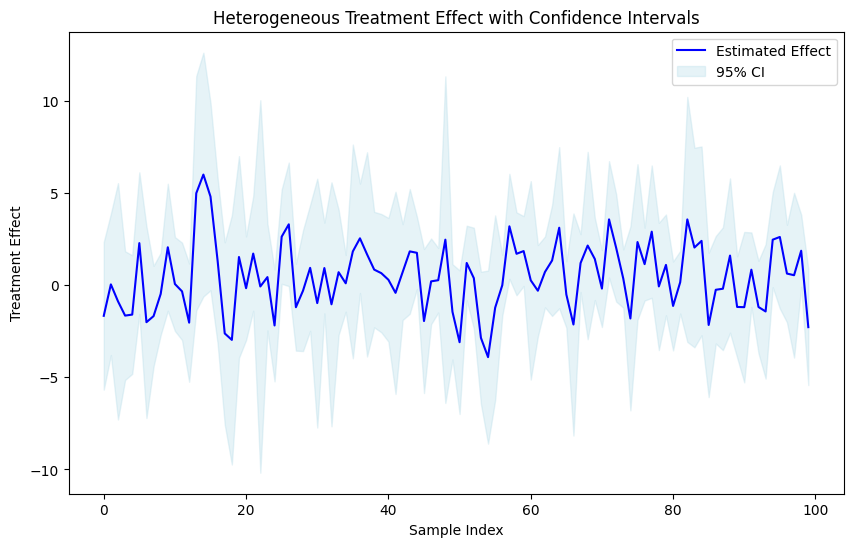

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the effect
plt.plot(eff, label='Estimated Effect', color='blue')

# Plot the confidence intervals
plt.fill_between(np.arange(eff.shape[0]), lb, ub, color='lightblue', alpha=0.3, label='95% CI')

# Labels and legend
plt.xlabel('Sample Index')
plt.ylabel('Treatment Effect')
plt.title('Heterogeneous Treatment Effect with Confidence Intervals')
plt.legend()

plt.show()

In [ ]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])